# ダイコン画像処理　試作プログラム
処理対象画像を変えたい場合はファイル名を書き換えてください。
画像ファイルと自作細線化ライブラリ thin（のフォルダ） はこのファイルと同じフォルダに入れておく必要があります

処理対象画像　 daikon1.jpg (445, 334, 3)


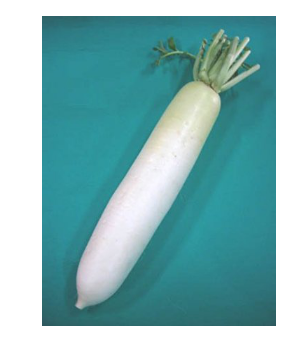

エッジ画像


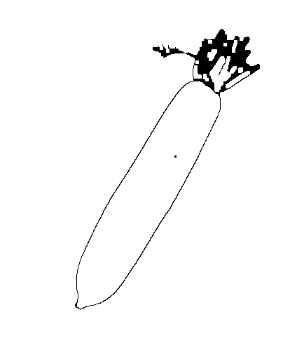

黒領域数= 3 白画素数 143763 黒領域画素数 [4858    9]
ラベル画像（エッジ）


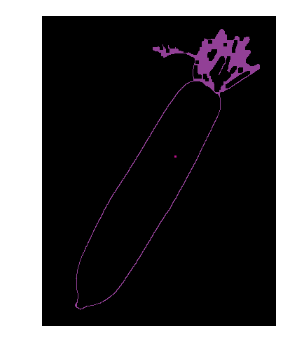

微小領域の除去後（エッジ）


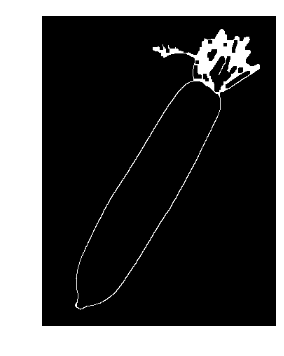

ラベル数 黒画素数 白領域画素数リスト
13 4858 [117412     30     96     25    157    985     25    143     53    263
     64  24519]
領域ラベル画像


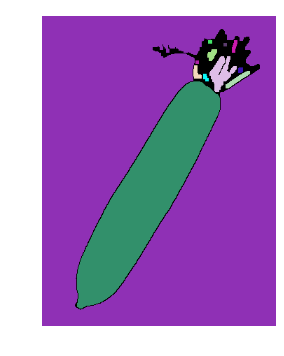

[ 1 12  6 10  5  8  3 11  9  2  7  4] [  4858 117412     30     96     25    157    985     25    143     53
    263     64  24519] 
大根の領域は 12 番目
大根の根の部分を抽出した画像


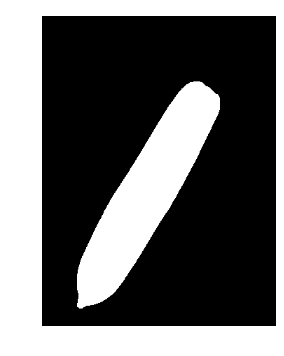

最大半径= 38.5535
距離画像


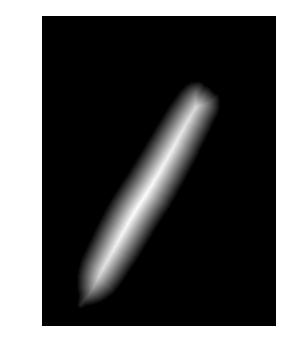

スケルトン画像


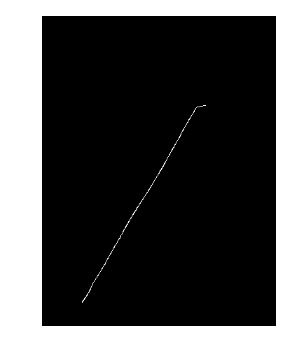

スケルトンから画像を復元(確認)


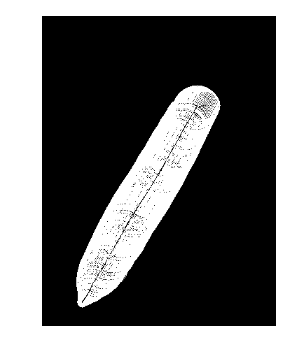

基準点 170 ( 147.0 258.0 )
基準点 194 ( 147.0 258.0 )
下側修正量 0.4207635450516136 (-177.50774630984418 -> -177.9285098548958)
上側修正量 3.490186408194461 (155.03870484495155 -> 158.528891253146)


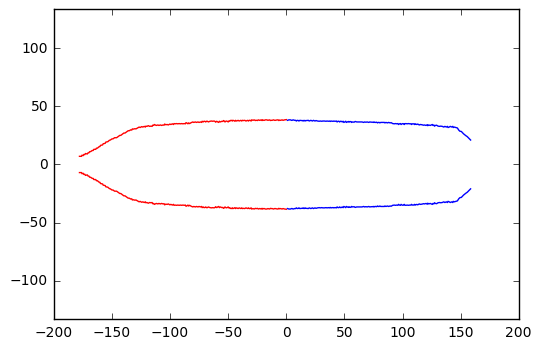

中心軸の画素数=365


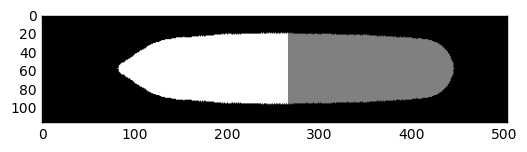

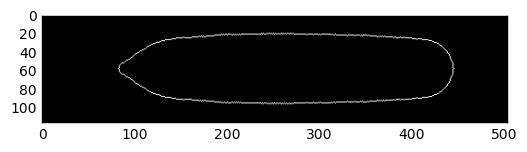

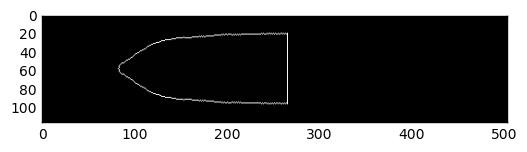

    0:(a,b,err) = (    0.3145,    0.0000,     0.0396)
  100:(a,b,err) = (    0.3241,    0.2781,     0.0380)
  200:(a,b,err) = (    0.3584,    0.5958,     0.0359)
  300:(a,b,err) = (    0.4100,    0.9729,     0.0330)
  400:(a,b,err) = (    0.4997,    1.4437,     0.0284)
  500:(a,b,err) = (    0.6986,    2.0687,     0.0196)
  600:(a,b,err) = (    1.1353,    2.7100,     0.0073)
  700:(a,b,err) = (    1.4678,    2.8626,     0.0043)
  800:(a,b,err) = (    1.6255,    2.8793,     0.0038)
  900:(a,b,err) = (    1.7130,    2.8837,     0.0037)
 1000:(a,b,err) = (    1.7664,    2.8855,     0.0036)


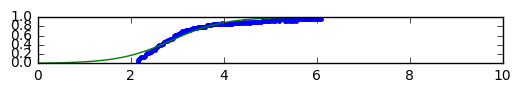

In [23]:
# -*- coding: utf-8 -*-A
import cv2
#import matplotlib
#%matplotlib nbagg
#matplotlib.use('nbagg') 

import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# plt.hold(False)

# 下の２つは自作ライブラリ
from thin.thin import getSkelline
from fit import fit1 as fit
# 処理対象画像
imgfile = 'pics/daikon1.jpg'

# 画像表示用関数
# グレイ画像の表示
def pltgry(img):
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB))
    plt.show()

# カラー画像の表示
def pltcol(img):
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

#  ラベルデータからラベルごとに色分けした画像を生成して表示 
def getlabelimage(labels, num_labels):
    dst = np.zeros(labels.shape+(3,),dtype=np.uint8)
    colors = []
    for i in range(1, num_labels+1):
       colors.append(np.array([random.randint(100, 255), random.randint(0, 255), random.randint(0, 255)]))

    for y in range(0, labels.shape[0]):
        for x in range(0, labels.shape[1]):
            if labels[y, x] > 0:
                dst[y, x] = colors[labels[y, x]]
            else:
                dst[y, x] = [0, 0, 0]
    return dst


# スケルトン（距離の極大点）の抽出
''' 
def skelton(img):
    ( height,width) = img.shape
    result = np.zeros_like(img)
    for i in range(1,height-1):
        for j in range(1,width-1):
            if isPolar(img,i,j):
                result[i][j]=img[i][j]
    return result


# 極値かどうかの判定
def isPolar(img, i, j):
    rv = True
    if img[i][j] == 0:
        rv = False
    if int(img[i][j]) < int(img[i -1][j]):
        rv = False
    if int(img[i][j]) < int(img[i +1][j]):
        rv = False
    if int(img[i][j]) < int(img[i][j -1]):
        rv = False
    if int(img[i][j]) < int(img[i][j +1]):
        rv = False 
    if int(img[i][j]) < int(img[i -1][j -1]):
        rv = False
    if int(img[i][j]) < int(img[i -1][j +1]):
        rv = False
    if int(img[i][j]) < int(img[i +1][j -1]):
        rv = False
    if int(img[i][j]) < int(img[i +1][j +1]):
        rv = False
    return rv

# スケルトンのリストを生成する関数
def skellist(img):
    (height,width) = img.shape
    result = []
    for i in range(1,height-1):
        for j in range(1,width-1):
            if img[i][j]>0:
                result.append([i,j,img[i][j]])
    return result
'''

# スケルトンのリストを生成する関数、細線化バージョン
def skellist(skel, dist):
    # skel 細線化済み画像データ
    # dist 距離画像データ
    # bwの白(255)連結成分を細線化し、残った画素の座標と距離データからなるタプルのリストを返す
    (height,width) = skel.shape
    result = []
    for i in range(1,height-1):
        for j in range(1,width-1):
            if skel[i][j]>0:
                result.append([i,j,dist[i][j]])
    return result

# スケルトンデータから2値画像データを復元 （検証のため）
'''def skel2img(skeldata,shape):
    img = np.zeros(shape,dtype='uint8')
    for i in range (len(skeldata)):
        cv2.circle(img,(skeldata[i][1],skeldata[i][0]),int(skeldata[i][2]),(255,255,255))
    return img
'''
# スケルトンデータから2値画像データを復元 （検証のため）
def skel2img(skeldata,shape,skelimg):
    img = np.zeros(shape,dtype='uint8')
    mask = cv2.merge((skelimg,skelimg,skelimg))
    for i in range (len(skeldata)):
        cv2.circle(img,(skeldata[i][1],skeldata[i][0]),int(skeldata[i][2]),(255,255,255))
    return cv2.bitwise_xor(img,mask)

# スケルトンの位置データ補正
def recalcDistanceP(skdata,normP):
    # 曲線に沿った距離を求める。理屈では積分していけばいいが
    # デジタル画像では近い画素間の距離は誤差が大きいので10点ごとに
    # 基準点を設け、基準点間の距離の積算＋最寄りの基準点からの距離を
    # 曲線に沿った距離の近似に使う
    xnorm = skdata[normP][1]
    ynorm = skdata[normP][0]
    cnt = 0 # ベースからの画素数 
    accdistAtBase = 0 # 基準点から現在のベースまでの距離の積算
    predist = skdata[0][3]  # 先端のデータ（最も誤差が大きいはず）
    predist10 = skdata[normP-10]
    cnt1=0
    for sk in skdata[normP-1::-1]:
            cnt1 = cnt1+1
            y = sk[0]
            x = sk[1]
            sk[3] = accdistAtBase - np.sqrt((x-xnorm)**2 + (y - ynorm)**2) 
            cnt = cnt+1
            if cnt==10 :
                predist10=skdata[normP-cnt1-10]
                accdistAtBase = sk[3]
                (ynorm,xnorm) = (y,x)
                cnt = 0
    print(u"下側修正量 {} ({} -> {})".format(predist-skdata[0][3],predist,skdata[0][3]))
    xnorm = skdata[normP][1]
    ynorm = skdata[normP][0]
    cnt = 0 # ベースからの画素数 
    accdistAtBase = 0 # 基準点から現在のベースまでの距離の積算
    predist = skdata[-1][3]  # 葉元のデータ（こちらも誤差が大きいはず）
    for sk in skdata[normP+1::]:
            y = sk[0]
            x = sk[1]
            sk[3] = accdistAtBase + np.sqrt((x-xnorm)**2 + (y - ynorm)**2) 
            cnt = cnt+1
            if cnt==10 :
                accdistAtBase = sk[3]
                (ynorm,xnorm) = (y,x)
                cnt = 0
    print(u"上側修正量 {} ({} -> {})".format(skdata[-1][3]-predist,predist,skdata[-1][3]))

    
# スケルトンを直線状に再配置し、曲がりを補正した画像を生成する
def makeNormalizedImage(skdp):
    print("中心軸の画素数={}".format(len(skdp)))
    maxh = np.max(skdp[:,2]) # もっとも近い輪郭までの距離
    maxw = np.max(skdp[:,3]) # 基準点からの距離の最大値
    minw = np.min(skdp[:,3]) # 基準点からの距離の最小値
    nimg = np.zeros((int(3*maxh),int(1.5*(maxw-minw)),3),dtype=np.uint8) # 50%マージンで描画用エリアを確保
    cent = np.array((int(1.5*(-minw)),int(1.5*maxh))) # 基準点の画像内座標
    for i in range(len(skdp)):
        center = (int(skdp[i][3])+cent[0],cent[1])
        radius = int(skdp[i][2])
        color = (255,255,255) # White
        thickness = -1 # 塗りつぶし
        nimg = cv2.circle(nimg,center,radius,color,thickness)
    mask = nimg[:,cent[0]:,:]
    cv2.threshold(mask,127,128,cv2.THRESH_BINARY,dst=mask)
    nimg = cv2.cvtColor(nimg,cv2.COLOR_BGR2GRAY)
    return nimg

# 輪郭線の抽出
# mode 0  全体の輪郭　　mode 1 最大径より先だけの輪郭  mode 2 先の上半分だけ
def  getContour(img, mode):
    center = img.shape[0]/2
    if mode == 0:
        ret, bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY)        
    else:
        ret, bw = cv2.threshold(img,200,255,cv2.THRESH_BINARY)  
    image, contours, hierarchy = cv2.findContours(bw,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    if  mode ==2:
        cnt = []
        maxx = np.max(contours[:][0][1])
        for i in contours[0]:
            if i[0][1] >= center and i[0][0]<maxx :
                cnt.append([list(i[0])])
            contours = np.array([cnt])
    return image,contours


'''
メインプログラム
ここから
'''

def main():
    global imgfile
    plt.hold(True)
    # カラー画像の読み込み
    src = cv2.imread(imgfile) 
    # 同じ画像をグレー画像として読み込み
    gry = cv2.imread(imgfile,0)
    # エッジ画像の生成
    edge=cv2.Canny(gry,100, 150)   # パラメータは適当  

    # plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    print(u'処理対象画像　',imgfile,src.shape)
    pltcol(src)


    # 穴埋め
    kernel = np.ones((5,5),np.uint8)
    edge= cv2.morphologyEx(edge,cv2.MORPH_CLOSE, kernel)
    print(u'エッジ画像') 
    pltgry(~edge)

    # 黒連結成分のラベリング 
    output = cv2.connectedComponentsWithStats(edge, connectivity = 8)
    # Get the results
    num_labels = output[0]  # 連結成分の数
    labels = output[1] # ラベル画像
    stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
    menseki = stats[:,cv2.CC_STAT_AREA]
    centroids = output[3]
    print(u'黒領域数=',num_labels,u'白画素数',menseki[0],'黒領域画素数',menseki[1:])

    # 結果確認のために色付けしてみる
    dst = getlabelimage(labels,num_labels)
    print(u'ラベル画像（エッジ）')
    pltcol(dst)

    # 小領域の削除
    img= np.zeros(gry.shape,dtype=np.uint8)
    for i in range(1,num_labels ):
            if  stats[i][cv2.CC_STAT_AREA] > gry.shape[0]+gry.shape[1]:
                img = img + np.uint8(labels==i)*255
    edge = img       
    print(u'微小領域の除去後（エッジ）')
    pltgry(edge)

    # 白連結成分のラベリング 
    output = cv2.connectedComponentsWithStats(~edge, connectivity = 4)  # 白領域の場合は４連結処理であることに注意
    # Get the results
    num_labels = output[0]  # 連結成分の数
    labels = output[1] # ラベル画像
    stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
    menseki = stats[:,cv2.CC_STAT_AREA]
    print(u"ラベル数",u"黒画素数",u"白領域画素数リスト")
    print(num_labels,menseki[0],menseki[1:])

    dst = getlabelimage(labels,num_labels)
    print(u'領域ラベル画像')    
    pltcol(dst)

    # ２番めに大きな領域がダイコンの主要部分であると仮定する。
    sortedindex = menseki[1:].argsort()[::-1]+1  # ラベル番号を画素数でソーティングしたリスト
    dnum = sortedindex[1] # ２番めに値の大きいデータのインデックス。１番多い領域はおそらく背景なのでそれを覗いて一番画素が多い領域番号
    print(sortedindex,menseki,u'\n大根の領域は',dnum,u'番目')

    daikonimg = np.uint8(labels==dnum)*255 # 上で求めたラベル番号に一意する画素を255（白)にした画像
    print(u'大根の根の部分を抽出した画像') 
    pltgry(daikonimg)

    # 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
    # DIST_L１ 4近傍距離。DIST_L2　ユークリッド距離 DIST_C　８近傍距離
    dist = cv2.distanceTransform(daikonimg,cv2.DIST_L2,5)
    #距離画像を表示してみる
    # print(u'距離画像') 
    # pltgry(dist)

    # 最大の距離は？　　　これが最大半径となる
    maxR = np.max(dist)
    print(u'最大半径=',maxR)

    # 最大値が白（最大輝度）になるようダイナミックレンジの拡大をしてみる
    tmp = dist * 255/np.max(dist)
    distimg = tmp.astype('uint8')
    print(u'距離画像') 
    pltgry(distimg)

    # スケルトン画像の生成
    # skelimg = skelton(dist)
    skelimg = getSkelline(daikonimg)
    print(u'スケルトン画像')
    pltgry(skelimg)

    # スケルトンのリストを求める
    # skeltondata = skellist(skelton(dist))
    skeltondata = skellist(skelimg,dist)
   
    # 復元して結果を確認
    recallimg = skel2img(skeltondata,src.shape,skelimg)
    plt.axis('off')
    print(u'スケルトンから画像を復元(確認)')
    pltcol(recallimg)

    # skeltondata を numpy array へ変換
    skd = np.array(skeltondata)     

    # 黒画素から最も距離のある，内部の点を基準点として選ぶ
    normP = np.argmax(skd[:,2])
    xnorm = skd[normP][1]
    ynorm = skd[normP][0]

    print (u'基準点',normP,'(',xnorm,ynorm,')')

    # 基準点からの距離の配列を生成
    distance = np.array([np.sign(x-xnorm)*np.sqrt((x-xnorm)**2 + (y - ynorm)**2)  for (y,x) in skd[:,0:2]] ) 
    # 距離画像データの距離だけの配列を生成

    # 基準点からの距離でインデックスを並べ替え
    index = np.argsort(distance)
    skd = skd[index]
    distance = distance[index]
    skdp = np.array([ list(np.append(s,d)) for (s,d) in zip(skd,distance)])
    
    #  並べ替えたので基準点のインデックスを再度調べ直す
    normP = np.argmax(skd[:,2])
    print (u'基準点',normP,'(',xnorm,ynorm,')')

    # 軸に沿った距離のデータを生成する
    recalcDistanceP(skdp,normP)
    
    skdN = skdp[skdp[:,3]<= 0]
    skdP = skdp[skdp[:,3] > 0]

    # 横軸を基準点からのスケルトン位置までの距離，縦軸をそのスケルトンの距離データとしたグラフ                          
    plt.axis('equal')    
    plt.hold(True)
    ydata = np.array(skdN[:,2])
    xdata = np.array(skdN[:,3])
    plt.plot(xdata,ydata,'-',color=(1,0,0.0))
    plt.plot(xdata,-ydata,'-',color=(1,0,0.0))
    ydata = np.array(skdP[:,2])
    xdata = np.array(skdP[:,3])
    plt.plot(xdata,ydata,'-',color=(0,0,1.0))
    plt.plot(xdata,-ydata,'-',color=(0,0,1.0))
    plt.hold(False)
    plt.show()

    # 中心線を直線化して形状整形した画像の生成
    norzimg = makeNormalizedImage(skdp)
    pltgry(norzimg)
    
    # 輪郭線を再抽出 (mode 0 全体)
    bw,cnt = getContour(norzimg,0)
    cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
    pltgry(bw)
    
    # 輪郭線を再抽出 (mode 1 先端のみ)
    bw,cnt = getContour(norzimg,1)
    cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
    pltgry(bw)
    
    # 先端部分だけの点列の生成　(mode 2)
    bw,cnt = getContour(norzimg,2)
    xdata = [i[0][0]  for i in cnt[0]]
    ydata = [i[0][1]- bw.shape[0]/2 for i in cnt[0]] 
    plt.gca().set_aspect('equal',adjustable='box')
    plt.plot(xdata,ydata,"r")

    # 最大径を基準に正規化
    xdata = np.array(xdata)/maxR
    ydata = np.array(ydata)/maxR

    # Tensorflow でロジスティック近似
    fit((xdata,ydata),itr = 1000, alpha=0.5)
    
main()